# **<span style = 'color:blue'>Neural Basis Expansion Analysis Time Series (NBEATS) Interpretable model for predicting Smart Homes Indoor Temperature</span>**

## **<span style='color:green'> Contents:</span>**<a id="Table"></a>

* [Import the libraries](#Import)
* [Dataset Information](#Dataset)
* [Visualize the Time Series to study the original plot](#Visualize)
* [Feature Engineering & Data Preprocessing](#Preprocessing)
* [Build and Train Interpretable NBeats model](#Build)
    > * [Code to structure NBeats architecture](#Architecture)
    > * [Define NBEATS wrapper to create generic model and interpretable model](#NBEATS-wrapper)
    > * [Define Generic Block](#Generic)
    > * [Define Trend Block](#Trend)
    > * [Define Seasonality Block](#Seasonality)
    > * [Define Interpretable Block](#Interpretable)
    > * [Define quantile loss error function](#Loss)
    > * [Define plot implementation function](#Plot)
    > * [Model Building & Hypertuning of model](#Building)
    > * [Model Training](#Training)
    > * [Output Decomposition](#Decomposition)

* [Feature Selection](#Selection)
* [Build & Train Scikit-learn Multi-layer Perceptron (MLP) Regressor Model](#MLP)
* [MLP Model Evaluation](#MLP-Evaluation)
* [Build & Train ANN Model](#ANN)
* [ANN Model Evaluation](#Evaluation)
* [Final Forecast](#Forecast)

## **<span style = 'color:green'>1. Import the required libraries</span>**<a id ="Import"></a>

In [1]:
# Import data handling & numerical libraries
import pandas as pd
import numpy as np
from copy import copy
import datetime

# Import Data Visualization libraries
import seaborn as sb
import matplotlib.pyplot as plt

#import libraries for muting unnecessary warnings if needed
import warnings
warnings.filterwarnings('ignore')

## **<span style = 'color:green'>2. Dataset information</span>**<a id ='Dataset'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
The dataset collected from the monitor system mounted in a solar house corresponds to approximately 40 days of monitoring data. The Goal is to predict indoor temperature of a room (the Bedroom), in order to choose whether or not to activate the HVAC (Heating, Ventilation, and Air Conditioning) system. The data was sampled every minute, computing and uploading it smoothed with 15 minute means. The dataset includes dates, other sensor measurements, weather measurements and other information. It is a multivariate time-series dataset. It has been established that the power consumption attributed to HVAC accounts for 53.9 % of total consumption, and the energy required to maintain the temperature is less than that required to drop or raise it. As a result, a predictive model capable of predicting a room's indoor temperature (a short-term forecast of indoor temperature) would help in lowering overall energy consumption, by deciding whether or not to activate the HVAC system, at the appropriate time. Below displayed map provides an idea of locations of solar house sensors and actuators.

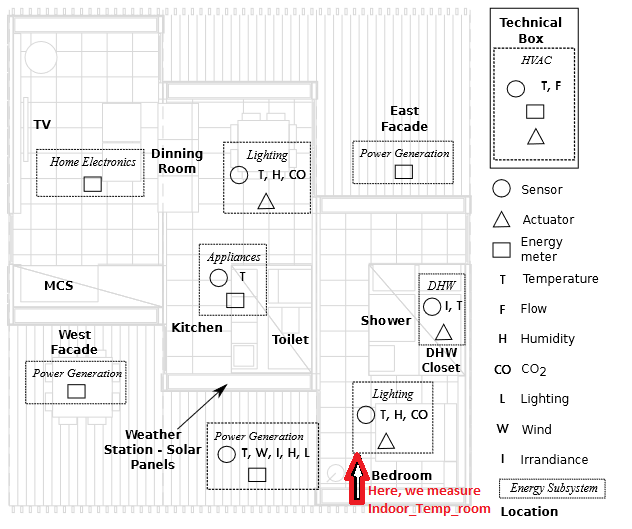

In [2]:
from IPython.display import Image
url = '../input/smart-homes-temperature-time-series-forecasting/Solar house sensors and actuators map.png'
Image(url,width=700, height=700)

In [3]:
df = pd.read_csv('../input/smart-homes-temperature-time-series-forecasting/train.csv', sep=',')
df_test = pd.read_csv('../input/smart-homes-temperature-time-series-forecasting/test.csv', sep=',')
#date = pd.date_range('1961-01-01', '2020-01-01', freq='M')
for data in (df, df_test):
    data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
    data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')   
    data['DateTime'] = data['Date'] + ' ' + data['Time']
    data['DateTime'] = pd.to_datetime(data['DateTime'])

## **<span style = 'color:green'>Visualize the Time Series to study the original plot</span>**<a id ='Visualize'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

In [4]:
import plotly.express as px
fig = px.line(df.drop(['Id', 'Date', 'Time','Day_of_the_week', 'DateTime'], axis = 1), x=df.index, 
              y=df.drop(['Id', 'Date', 'Time','Day_of_the_week', 'DateTime'], axis = 1).columns, title='Indoor Temperature in °C', width=1500)

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([dict(label="All",
                     method="update",
                     args=[{"visible": [True for _ in range(186)]},
                           {"title": "Indoor Temperature in °C ",
                            "annotations": []}])]) + list([
                dict(label=f"{j}",
                     method="update",
                     args=[{"visible": [True if i==idx else False for i in range(186)]},
                           {"title": f"{j}",
                            "annotations": []}]) for idx,j in enumerate(df.drop(['Id', 'Date', 'Time','Day_of_the_week'], axis = 1).columns[0:])])
            )])

fig.show()

## **<span style = 'color:green'>Feature Engineering & Data Preprocessing </span>**<a id ='Preprocessing'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
Code Credits: [Forecast with N-BEATS || Interpretable model](https://www.kaggle.com/code/gatandubuc/forecast-with-n-beats-interpretable-model/notebook)

In [5]:
class DataSet:
    """
    Preprocessing.
    """
    def __init__(self, horizon, back_horizon):
        self.horizon = horizon
        self.back_horizon = back_horizon
    
    def preprocessing(self, y, date, train_size=0.7, val_size=0.2):
        
        y = y.copy().astype('float')

        train = y[:int(train_size*len(y))]
        val = y[int(train_size*len(y))-self.back_horizon:int((train_size+val_size)*len(y))]
        test = y[int((train_size+val_size)*len(y))-self.back_horizon:]
        train_date = date[:int(train_size*len(y))]
        val_date = date[int(train_size*len(y))-self.back_horizon:int((train_size+val_size)*len(y))]
        test_date = date[int((train_size+val_size)*len(y))-self.back_horizon:]

        # Training set
        self.X_train, self.y_train, self.train_date = self.create_sequences(train, 
                                                                            train, 
                                                                            train_date,
                                                                            self.horizon, 
                                                                            self.back_horizon)
        # Validation set
        self.X_val, self.y_val, self.val_date = self.create_sequences(val,
                                                                      val,
                                                                      val_date,
                                                                      self.horizon,
                                                                      self.back_horizon)
        # Testing set
        self.X_test, self.y_test, self.test_date = self.create_sequences(test,
                                                                         test,
                                                                         test_date,
                                                                         self.horizon,
                                                                         self.back_horizon)

        # training on all database
        self.X_train_all, self.y_train_all, self.train_all_date = self.create_sequences(y, 
                                                                                        y,
                                                                                        date,
                                                                                        self.horizon,
                                                                                        self.back_horizon)
            
    @staticmethod
    def create_sequences(X, y, d, horizon, time_steps):
        Xs, ys, ds = [], [], []
        for col in range(X.shape[1]):
            for i in range(0, len(X)-time_steps-horizon, 1):
                Xs.append(X[i:(i+time_steps), col])
                ys.append(y[(i+time_steps):(i+time_steps+horizon), col])
                ds.append(d[(i+time_steps):(i+time_steps+horizon)])

        return np.array(Xs), np.array(ys), np.array(ds)

## **<span style='color:green'>Build and Train Interpretable NBeats model</span>**<a id ='Build'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
Neural Basis Expansion Analysis Time Series (NBEATS) is based on backward and forward residual links and a very deep stack of fully-connected layers. Model type can be ‘generic’ or ‘interpretable’. Interpretable models which describes series as a function of trend and seasonality, can help to better understand interactions between variables also.

### **<span style = 'color:brown'>Code to structure NBeats architecture</span>**<a id ='Architecture'></a>


Code Credits: [Forecast with N-BEATS || Interpretable model](https://www.kaggle.com/code/gatandubuc/forecast-with-n-beats-interpretable-model/notebook)

In [6]:
import tensorflow as tf
class Stack(tf.keras.layers.Layer):

    """A stack is a series of blocks where each block produce two outputs, the horizon and the back_horizon. 
    All of the outputs are sum up which compose the stack output while each residual back_horizon is given to the following block.
    
    Parameters
    ----------
    blocks: list of `TrendBlock`, `SeasonalityBlock` or `GenericBlock`.
        Define blocks in a stack.
    """
    def __init__(self, blocks, **kwargs):
        
        super().__init__(**kwargs)

        self._blocks = blocks

    def call(self, inputs):

        y_horizon = 0.
        for block in self._blocks:
            residual_y, y_back_horizon = block(inputs) # shape: (n_quantiles, Batch_size, horizon), (Batch_size, back_horizon)
            inputs = tf.subtract(inputs, y_back_horizon)
            y_horizon = tf.add(y_horizon, residual_y) # shape: (n_quantiles, Batch_size, horizon)

        return y_horizon, inputs

### **<span style = 'color:brown'>Define NBEATS wrapper to create generic model and interpretable model</span>**<a id ='NBEATS-wrapper'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

Code Credits: [Forecast with N-BEATS || Interpretable model](https://www.kaggle.com/code/gatandubuc/forecast-with-n-beats-interpretable-model/notebook)

In [7]:
class N_BEATS(tf.keras.Model):
    """This class compute the N-BEATS model. This is a univariate model which can be
     interpretable or generic. It's strong advantage is its internal structure which allows us 
     to extract the trend and the seasonality of a temporal serie. It's available from the attributes
     `seasonality` and `trend`. This is an unofficial implementation.

     `@inproceedings{
        Oreshkin2020:N-BEATS,
        title={{N-BEATS}: Neural basis expansion analysis for interpretable time series horizoning},
        author={Boris N. Oreshkin and Dmitri Carpov and Nicolas Chapados and Yoshua Bengio},
        booktitle={International Conference on Learning Representations},
        year={2020},
        url={https://openreview.net/forum?id=r1ecqn4YwB}
        }`
    
    Parameter
    ---------
    stacks: list of `Stack` layer.
        Define the stack to use in nbeats model. It can be full of `TrendBlock`, `SeasonalityBlock` or `GenereicBlock`.
    """
    def __init__(self, 
                 stacks,
                 **kwargs):
                
        super().__init__(**kwargs)

        self._stacks = stacks

    def call(self, inputs):
        self._residuals_y = tf.TensorArray(tf.float32, size=len(self._stacks)) # Stock trend and seasonality curves during inference
        y_horizon = 0.
        for idx, stack in enumerate(self._stacks):
            residual_y, inputs = stack(inputs)
            self._residuals_y.write(idx, residual_y)
            y_horizon = tf.add(y_horizon, residual_y)

        return y_horizon

    @property
    def seasonality(self):
        return self._residuals_y.stack()[1]

    @property
    def trend(self):
        return self._residuals_y.stack()[0]

### **<span style = 'color:brown'>Define Generic Block</span>**<a id ='Generic'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

Code Credits: [Forecast with N-BEATS || Interpretable model](https://www.kaggle.com/code/gatandubuc/forecast-with-n-beats-interpretable-model/notebook)

In [8]:
from tensorflow import keras
class GenericBlock(keras.layers.Layer):
    """
    Generic block definition as described in the paper. 
    We can't have explanation from this kind of block because g coefficients are learnt.
    
    Parameter
    ---------
    horizon: integer
        Horizon time to horizon.
    back_horizon: integer
        Past to rebuild.
    nb_neurons: integer
        Number of neurons in Fully connected layers.
    back_neurons: integer
        Number of back_horizon expansion coefficients.
    fore_neurons: integer
        Number of horizon expansion coefficients.
    """
    def __init__(self, horizon, 
                       back_horizon, 
                       n_neurons, 
                       n_quantiles,
                       dropout_rate,
                        **kwargs):
        
        super().__init__(**kwargs)
        
        self._FC_stack = [keras.layers.Dense(n_neurons, 
                                            activation='relu', 
                                            kernel_initializer="glorot_uniform") for _ in range(4)]
        
        self._dropout = tf.keras.layers.Dropout(dropout_rate)

        
        self._FC_back_horizon = self.add_weight(shape=(n_neurons, n_neurons), 
                                           trainable=True,
                                           initializer="glorot_uniform",
                                           name='FC_back_horizon_generic')

        self._FC_horizon = self.add_weight(shape=(n_quantiles, n_neurons, n_neurons), 
                                           trainable=True,
                                           initializer="glorot_uniform",
                                           name='FC_horizon_generic')
        
        self._back_horizon = keras.layers.Dense(back_horizon, 
                                           kernel_initializer="glorot_uniform")
        
        self._horizon = keras.layers.Dense(horizon, 
                                           kernel_initializer="glorot_uniform")
        
    def call(self, inputs):
        # shape: (Batch_size, back_horizon)
        for dense_layer in self._FC_stack:
            inputs = dense_layer(inputs) # shape: (Batch_size, nb_neurons)
            inputs = self._dropout(inputs, training=True) # We bind first layers by a dropout 
            
        theta_horizon = inputs @ self._FC_horizon # shape: (n_quantiles, Batch_size, 2 * fourier order)
        theta_back_horizon = inputs @ self._FC_back_horizon # shape: (Batch_size, 2 * fourier order)
        
        y_back_horizon = self._back_horizon(theta_back_horizon) # shape: (Batch_size, back_horizon)
        y_horizon = self._horizon(theta_horizon) # shape: (n_quantiles, Batch_size, horizon)
        
        return y_horizon, y_back_horizon

### **<span style = 'color:brown'>Define Trend Block</span>**<a id ='Trend'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

Code Credits: [Forecast with N-BEATS || Interpretable model](https://www.kaggle.com/code/gatandubuc/forecast-with-n-beats-interpretable-model/notebook)

In [9]:
class TrendBlock(tf.keras.layers.Layer):
    """ Trend block definition. Output layers are constrained which define polynomial function of small degree p.
    Therefore it is possible to get explanation from this block.
    
    Parameter
    ---------
    p_degree: integer
        Degree of the polynomial function.
    horizon: integer
        Horizon time to horizon.
    back_horizon: integer
        Past to rebuild.
    n_neurons: integer
        Number of neurons in Fully connected layers.
    n_quantiles: Integer.
        Number of quantiles in `QuantileLossError`.
    """
    def __init__(self, 
                 horizon, 
                 back_horizon,
                 p_degree,   
                 n_neurons, 
                 n_quantiles, 
                 dropout_rate,
                 **kwargs):

        super().__init__(**kwargs)
        
        self._p_degree = tf.reshape(tf.range(p_degree + 1, dtype='float32'), shape=(-1, 1)) # Shape (-1, 1) in order to broadcast horizon to all p degrees
        self._horizon = tf.cast(horizon, dtype='float32') 
        self._back_horizon = tf.cast(back_horizon, dtype='float32')
        self._n_neurons = n_neurons 
        self._n_quantiles = n_quantiles

        self._FC_stack = [tf.keras.layers.Dense(n_neurons, 
                                            activation='relu', 
                                            kernel_initializer="glorot_uniform") for _ in range(4)]
        
        self._dropout = tf.keras.layers.Dropout(dropout_rate)
        
        self._FC_back_horizon = self.add_weight(shape=(n_neurons, p_degree + 1), 
                                           trainable=True,
                                           initializer="glorot_uniform",
                                           name='FC_back_horizon_trend')
        
        self._FC_horizon = self.add_weight(shape=(n_quantiles, n_neurons, p_degree + 1),
                                           trainable=True,
                                           initializer="glorot_uniform",
                                           name='FC_horizon_trend')

        self._horizon_coef = (tf.range(self._horizon) / self._horizon) ** self._p_degree
        self._back_horizon_coef = (tf.range(self._back_horizon) / self._back_horizon) ** self._p_degree
        
    def call(self, inputs):

        for dense in self._FC_stack:
            inputs = dense(inputs) # shape: (Batch_size, n_neurons)
            inputs = self._dropout(inputs, training=True) # We bind first layers by a dropout 
            
        theta_back_horizon = inputs @ self._FC_back_horizon # shape: (Batch_size, p_degree)
        theta_horizon = inputs @ self._FC_horizon # shape: (n_quantiles, Batch_size, p_degree)

        y_back_horizon = theta_back_horizon @ self._back_horizon_coef # shape: (Batch_size, back_horizon)
        y_horizon = theta_horizon @ self._horizon_coef # shape: (n_quantiles, Batch_size, horizon)
        
        return y_horizon, y_back_horizon
    

### **<span style = 'color:brown'>Define Seasonality Block</span>**<a id ='Seasonality'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

Code Credits: [Forecast with N-BEATS || Interpretable model](https://www.kaggle.com/code/gatandubuc/forecast-with-n-beats-interpretable-model/notebook)

In [10]:
class SeasonalityBlock(tf.keras.layers.Layer):
    """Seasonality block definition. Output layers are constrained which define fourier series. 
    Each expansion coefficent then become a coefficient of the fourier serie. As each block and each 
    stack outputs are sum up, we decided to introduce fourier order and multiple seasonality periods.
    Therefore it is possible to get explanation from this block.
    
    Parameters
    ----------
    horizon: integer
        Horizon time to horizon.
    back_horizon: integer
        Past to rebuild.
    n_neurons: integer
        Number of neurons in Fully connected layers.
    periods: Integer.
        fourier serie period. The paper set this parameter to `horizon/2`.
    back_periods: Integer.
        fourier serie back period. The paper set this parameter to `back_horizon/2`.
    horizon_fourier_order: Integer.
        Higher values signifies complex fourier serie
    back_horizon_fourier_order: Integer.
        Higher values signifies complex fourier serie
    n_quantiles: Integer.
        Number of quantiles in `QuantileLossError`.
    """
    def __init__(self,
                 horizon,
                 back_horizon,
                 n_neurons, 
                 periods, 
                 back_periods, 
                 horizon_fourier_order,
                 back_horizon_fourier_order,
                 n_quantiles,
                 dropout_rate,
                 **kwargs):
        
        super().__init__(**kwargs)

        self._horizon = horizon
        self._back_horizon = back_horizon
        self._periods = tf.cast(tf.reshape(periods, (1, -1)), 'float32') # Broadcast horizon on multiple periods
        self._back_periods = tf.cast(tf.reshape(back_periods, (1, -1)), 'float32')  # Broadcast back horizon on multiple periods
        self._horizon_fourier_order = tf.reshape(tf.range(horizon_fourier_order, dtype='float32'), shape=(-1, 1)) # Broadcast horizon on multiple fourier order
        self._back_horizon_fourier_order = tf.reshape(tf.range(back_horizon_fourier_order, dtype='float32'), shape=(-1, 1)) # Broadcast horizon on multiple fourier order

        # Workout the number of neurons needed to compute seasonality coefficients
        horizon_neurons = tf.reduce_sum(2 * horizon_fourier_order)
        back_horizon_neurons = tf.reduce_sum(2 * back_horizon_fourier_order)
        
        self._FC_stack = [tf.keras.layers.Dense(n_neurons, 
                                               activation='relu', 
                                               kernel_initializer="glorot_uniform") for _ in range(4)]
        
        self._dropout = tf.keras.layers.Dropout(dropout_rate)   
        
        self._FC_back_horizon = self.add_weight(shape=(n_neurons, back_horizon_neurons), 
                                           trainable=True,
                                           initializer="glorot_uniform",
                                           name='FC_back_horizon_seasonality')

        self._FC_horizon = self.add_weight(shape=(n_quantiles, n_neurons, horizon_neurons), 
                                           trainable=True,
                                           initializer="glorot_uniform",
                                           name='FC_horizon_seasonality')
        
        # Workout cos and sin seasonality coefficents
        time_horizon = tf.range(self._horizon, dtype='float32') / self._periods
        horizon_seasonality = 2 * np.pi * self._horizon_fourier_order * time_horizon
        self._horizon_coef = tf.concat((tf.cos(horizon_seasonality), 
                                          tf.sin(horizon_seasonality)), axis=0)

        time_back_horizon = tf.range(self._back_horizon, dtype='float32') / self._back_periods
        back_horizon_seasonality = 2 * np.pi * self._back_horizon_fourier_order * time_back_horizon
        self._back_horizon_coef = tf.concat((tf.cos(back_horizon_seasonality), 
                                        tf.sin(back_horizon_seasonality)), axis=0)
        
    def call(self, inputs):

        for dense in self._FC_stack:
            inputs = dense(inputs) # shape: (Batch_size, nb_neurons)
            inputs = self._dropout(inputs, training=True) # We bind first layers by a dropout 

        theta_horizon = inputs @ self._FC_horizon # shape: (n_quantiles, Batch_size, 2 * fourier order)
        theta_back_horizon = inputs @ self._FC_back_horizon # shape: (Batch_size, 2 * fourier order)
        
        y_horizon = theta_horizon @ self._horizon_coef # shape: (n_quantiles, Batch_size, horizon)
        y_back_horizon = theta_back_horizon @ self._back_horizon_coef # shape: (Batch_size, back_horizon)
    
        return y_horizon, y_back_horizon

### **<span style = 'color:brown'>Define Interpretable Block</span>**<a id ='Interpretable'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
Code Credits: [Forecast with N-BEATS || Interpretable model](https://www.kaggle.com/code/gatandubuc/forecast-with-n-beats-interpretable-model/notebook)

In [11]:
def create_interpretable_nbeats(horizon, 
                                   back_horizon,
                                   p_degree,   
                                   trend_n_neurons, 
                                   seasonality_n_neurons, 
                                   periods, 
                                   back_periods, 
                                   horizon_fourier_order,
                                   back_horizon_fourier_order,
                                   n_quantiles, 
                                   share=True,
                                   dropout_rate=0.1,
                                   **kwargs):
    
    """Wrapper to create interpretable model. check nbeats doc to know more about parameters."""
    
    if share is True:
        trend_block = TrendBlock(horizon=horizon, 
                                 back_horizon=back_horizon, 
                                 p_degree=p_degree, 
                                 n_neurons=trend_n_neurons, 
                                 n_quantiles=n_quantiles,
                                 dropout_rate=dropout_rate,
                                 **kwargs)
        
        seasonality_block = SeasonalityBlock(horizon=horizon, 
                                 back_horizon=back_horizon, 
                                 periods=periods, 
                                 back_periods=back_periods, 
                                 horizon_fourier_order=horizon_fourier_order,
                                 back_horizon_fourier_order = back_horizon_fourier_order,
                                 n_neurons=seasonality_n_neurons, 
                                 n_quantiles=n_quantiles,dropout_rate=dropout_rate, **kwargs)
        
        trendblocks = [trend_block for _ in range(3)]
        seasonalityblocks = [seasonality_block for _ in range(3)]
    else:
        trendblocks = [TrendBlock(horizon=horizon, 
                                 back_horizon=back_horizon, 
                                 p_degree=p_degree, 
                                 n_neurons=trend_n_neurons, 
                                 n_quantiles=n_quantiles, 
                                  dropout_rate=dropout_rate,
                                 **kwargs) for _ in range(3)]
        seasonalityblocks = [SeasonalityBlock(horizon=horizon, 
                                 back_horizon=back_horizon, 
                                 periods=periods, 
                                 back_periods=back_periods, 
                                 horizon_fourier_order=horizon_fourier_order,
                                 back_horizon_fourier_order = back_horizon_fourier_order,
                                 n_neurons=seasonality_n_neurons, 
                                 n_quantiles=n_quantiles,dropout_rate=dropout_rate, **kwargs) for _ in range(3)]
        
    trendstacks = Stack(trendblocks)
    seasonalitystacks = Stack(seasonalityblocks)
    
    return N_BEATS([trendstacks, seasonalitystacks])

def create_generic_nbeats(horizon,
                          back_horizon, 
                           n_neurons, 
                           n_quantiles,
                           n_blocks,
                           n_stacks,
                           share=True,
                           dropout_rate=0.1,
                           **kwargs):

    """Wrapper to create interpretable model. check nbeats doc to know more about parameters."""
    generic_stacks = []
    if share is True:
        for stack in range(n_stacks):
            generic_block = GenericBlock(horizon=horizon, 
                              back_horizon=back_horizon, 
                               n_neurons=n_neurons, 
                               n_quantiles=n_quantiles,
                               dropout_rate=0.1,
                               **kwargs)

            generic_blocks = [generic_block for _ in range(n_blocks)]
            generic_stacks.append(Stack(generic_blocks))
            
    else:
        for stack in range(n_stacks):
            generic_blocks = [GenericBlock(horizon=horizon, 
                              back_horizon=back_horizon, 
                               n_neurons=n_neurons, 
                               n_quantiles=n_quantiles, 
                               dropout_rate=0.1,
                               **kwargs) for _ in range(n_blocks)]
            
            generic_stacks.append(Stack(generic_blocks))
    
    return N_BEATS(generic_stacks)

### **<span style = 'color:brown'>Define quantile loss error function</span>**<a id ='Loss'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
Code Credits: [Forecast with N-BEATS || Interpretable model](https://www.kaggle.com/code/gatandubuc/forecast-with-n-beats-interpretable-model/notebook)

In [12]:
"""Functions to assess loss."""
from tensorflow.python.keras.losses import LossFunctionWrapper
from tensorflow.python.keras.utils import losses_utils
def quantile_loss(y_true, y_pred, quantiles):
    
    """Calculate the quantile loss function, summed across all quantile outputs.

    Parameters
    ----------
    y_true : ndarray or dataframe or list or Tensor of shape `[batch_size, d0, .. dN]`.
        Ground truth values.

    y_pred : ndarray or dataframe or list or Tensor of shape `[batch_size, d0, .. dN]`.
        The predicted values.

    n_quantiles : ndarray or dataframe or list or Tensor of shape `[batch_size, d0, .. dN]`.
        The set of output n_quantiles on which is calculated the quantile loss.

    Returns
    -------
    error : Tensor of shape `[batch_size, d0, .. dN]`.
        The error in %.
    """

    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    quantiles = tf.convert_to_tensor(quantiles)
    diff = tf.transpose(y_true - y_pred)

    quantile_loss = (quantiles * tf.clip_by_value(diff, 0., np.inf) +
                    (1 - quantiles) * tf.clip_by_value(-diff, 0., np.inf))
    
    M = tf.cast(tf.shape(y_true)[0], dtype=tf.float32)
    error = quantile_loss / M
    
    sum_quantiles = tf.reduce_sum(error, axis=-1)
    return tf.reduce_sum(sum_quantiles, axis=tf.range(sum_quantiles.shape.rank-1))

class QuantileLossError(LossFunctionWrapper):
    """Calculate the quantile loss error between `y_true`and `y_pred` across all examples.
    Standalone usage:
    >>> y_true = [[0., 1., 2.], [0., 0., 4.]]
    >>> y_pred = [[1., 1., 2.], [1., 0., 3.]]
    >>> # Using 'auto'/'sum_over_batch_size' reduction type.
    >>> ql = QuantileLossError(quantiles=[0.5])
    >>> ql(y_true, y_pred).numpy()
    0.5
    >>> # Calling with 'sample_weight'.
    >>> ql(y_true, y_pred, sample_weight=[0.7, 0.3]).numpy()
    0.25
    >>> # Using 'AUTO' reduction type.
    >>> ql = QuantileLossError(quantiles=[0.5],
    ...     reduction=tf.keras.losses.Reduction.AUTO)
    >>> ql(y_true, y_pred).numpy()
    0.25
    >>> # Using 'none' reduction type.
    >>> ql = QuantileLossError(quantiles=[0.5],
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> ql(y_true, y_pred).numpy()
    array([0.25, 0.25], dtype=float32)
    >>> # Using multiple quantiles.
    >>> ql = QuantileLossError(quantiles=[0.1, 0.5, 0.9])
    >>> ql(y_true, y_pred).numpy()
    1.5

    Usage with the `compile()` API:
    ```python
    model.compile(optimizer='sgd', loss=tf.keras.losses.QuantileLossError())
    ```
    """

    def __init__(self,
                 quantiles,
                 reduction=losses_utils.ReductionV2.SUM,
                 name='quantile_loss'):
        super(QuantileLossError, self).__init__(
            quantile_loss, quantiles=quantiles, name=name, reduction=reduction)

### **<span style = 'color:brown'>Define plot implementation function</span>**<a id ='Plot'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
Code Credits: [Forecast with N-BEATS || Interpretable model](https://www.kaggle.com/code/gatandubuc/forecast-with-n-beats-interpretable-model/notebook)

In [13]:
def confidence_interval(time_series, quantile):
    
    mean = tf.reduce_mean(time_series, axis=0)
    standard_deviation = tf.math.reduce_std(time_series, axis=0)
    
    # (-1, 1, 1, 1) Broadcast std with shape (quantile, timesteps, horizon)
    max_interval = mean + tf.reshape(tfd.Normal(loc=0, scale=1).quantile(quantile), (-1, 1, 1, 1)) * standard_deviation 
    min_interval = mean - tf.reshape(tfd.Normal(loc=0, scale=1).quantile(quantile), (-1, 1, 1, 1)) * standard_deviation 
    
    return mean, min_interval, max_interval

def fig_add_trace(fig, y, x, row, col):
    for data, fill, name, color, showlegend in y:
        fig.add_trace(
            go.Scatter(
                name=name,
                x=x,
                y=data,
                fill=fill,
                line=dict(color=color),
                fillcolor=color,
                showlegend=showlegend),
            row=row, col=col)
        
def plot_results_nbeats(y_pred,
                        date_outputs,
                        y_true=None,
                        date_history=None,
                        seasonality=None,
                        trend=None):
    
    date = pd.to_datetime(date_outputs[0])
    date_history = date_history if date_history is not None else pd.to_datetime(date_outputs[0])
    y_pred_mean, y_pred_min_interval, y_pred_max_interval = confidence_interval(y_pred, [0.99])
    
    if trend is None:
        fig = make_subplots(
        subplot_titles=['True Vs Predicted','Trend','Seasonality', 'Overall trend', 'Overall seasonality'],
        rows=1, cols=1,
        vertical_spacing=0.1,
        horizontal_spacing=0.05,
        specs=[[{"type": "scatter"}]])
        
        if y_true is not None:
    
            # Trace ground truth
            fig.add_trace(
                    go.Scatter(
                        name="y_true",
                        x=date_history,
                        y=y_true[0],
                        line=dict(color="green")),
                    row=1, col=1
                )  
    
    else:
        fig = make_subplots(
        subplot_titles=['True Vs Predicted','Trend','Seasonality', 'Overall trend', 'Overall seasonality'],
        rows=3, cols=2,
        vertical_spacing=0.1,
        horizontal_spacing=0.05,
        column_widths=[0.8, 0.6],
        row_heights=[0.8, 0.8, 0.8],
        specs=[[{"type": "scatter", "rowspan": 2}, {"type": "scatter"}],
               [        None      , {"type": "scatter"}], 
               [{"type": "scatter", "colspan": 2}, None]])
        
        if y_true is not None:
    
            # Trace ground truth
            fig.add_trace(
                    go.Scatter(
                        name="y_true",
                        x=date_history,
                        y=y_true[0],
                        line=dict(color="green")),
                    row=1, col=1
                )  
            
        trend_mean, trend_min_interval, trend_max_interval = confidence_interval(trend, [0.99])

        fig_add_trace(fig, zip([trend_min_interval[0, 1, 0], trend_max_interval[0, 1, 0], 
                                trend_mean[1, 0]], 
                              ['none','tonextx', 'none'],
                              ['Confidence interval', 'Confidence interval', 'Average'],
                              ['rgba(153,50,204, 0.7)', 'rgba(153,50,204, 0.7)', 
                               'darkorange'], 
                              [ False, False, False]), date, row=1, col=2)
        
            # Trace mean
        fig_add_trace(fig, zip([tf.reduce_mean(trend_min_interval, axis=2)[0, 1], tf.reduce_mean(trend_max_interval, axis=2)[0, 1], 
                            tf.reduce_mean(trend_mean, axis=1)[1]], 
                          ['none','tonextx', 'none'],
                          ['Confidence interval', 'Confidence interval', 'Average'],
                          ['rgba(153,50,204, 0.7)', 'rgba(153,50,204, 0.7)', 
                           'darkorange'], 
                          [False, False, False]), date, row=3, col=1)
    
    # Trace mean
    fig_add_trace(fig, zip([y_pred_min_interval[0, 0, 0], y_pred_max_interval[0, 2, 0], 
                            y_pred_min_interval[0, 1, 0], y_pred_max_interval[0, 1, 0], 
                            y_pred_mean[1, 0]], 
                          ['none', 'tonextx', 'none','tonextx', 'none'],
                          ['Prediction interval', 'Prediction interval', 'Confidence interval', 'Confidence interval', 'Average'],
                          ['rgba(255, 0, 0, 0.2)', 'rgba(255, 0, 0, 0.2)', 
                           'rgba(153,50,204, 0.7)', 'rgba(153,50,204, 0.7)', 
                           'darkorange'], 
                          [False, True, False, True, True]), date, row=1, col=1)
    
    # Trace seasonality
    if seasonality is not None:
        seasonality_mean, seasonality_min_interval, seasonality_max_interval = confidence_interval(seasonality, [0.99])
        fig_add_trace(fig, zip([seasonality_min_interval[0, 1, 0], seasonality_max_interval[0, 1, 0], 
                                seasonality_mean[1, 0]], 
                              ['none','tonextx', 'none'],
                              ['Confidence interval', 'Confidence interval', 'Average'],
                              ['rgba(153,50,204, 0.7)', 'rgba(153,50,204, 0.7)', 
                               'darkorange'], 
                              [False, False, False]), date, row=2, col=2)
    
    return fig

### **<span style = 'color:brown'>Model Building & Hypertuning of model</span>**<a id ='Building'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
Let's take 2 days of horizon and a double of history.

In [14]:
back_horizon = 2 * 200 # (24*4 = 96 values with 15 minutes interval in a day)
horizon = 200

dataset = DataSet(horizon, back_horizon)
dataset.preprocessing(df[['Indoor_temperature_room']].values, df.DateTime, train_size=0.60, val_size=0.20)

Code Credits: [Forecast with N-BEATS || Interpretable model](https://www.kaggle.com/code/gatandubuc/forecast-with-n-beats-interpretable-model/notebook)

In [15]:
def model_builder(hp):
    
    hp_n_neurons_trend = hp.Int('neurons_trend', min_value = 4, max_value=16, step=2)
    hp_n_neurons_seas = hp.Int('neurons_seas', min_value = 4, max_value=16, step=2)
    hp_periods = hp.Int('periods', min_value = 1, max_value = horizon, step = 30)
    hp_back_periods = hp.Int('back_periods', min_value = 1, max_value = back_horizon, step = 30)
    hp_share = hp.Boolean('share')
    
    model_nbeats = create_interpretable_nbeats(horizon=horizon, 
                                               back_horizon=back_horizon,
                                               p_degree=1,   
                                               trend_n_neurons=hp_n_neurons_trend, 
                                               seasonality_n_neurons=hp_n_neurons_seas, 
                                               periods=hp_periods, 
                                               back_periods=hp_back_periods, 
                                               horizon_fourier_order=hp_periods,
                                               back_horizon_fourier_order=hp_back_periods,
                                               n_quantiles=3, 
                                               share=hp_share)

    model_nbeats.compile(loss=QuantileLossError([0.1, 0.5, 0.9]), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                         metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model_nbeats
!pip install -q -U keras-tuner
import keras_tuner as kt
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dira',
                     project_name = 'temp')

import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

tuner.search(dataset.X_train, dataset.y_train, epochs = 20, 
             validation_data = (dataset.X_val, dataset.y_val), callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 00m 10s]
val_loss: 518.877197265625

Best val_loss So Far: 432.1576232910156
Total elapsed time: 00h 03m 36s


### **<span style = 'color:brown'>Model Training</span>**<a id ='Training'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

Code Credits: [Forecast with N-BEATS || Interpretable model](https://www.kaggle.com/code/gatandubuc/forecast-with-n-beats-interpretable-model/notebook)

In [16]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.build((None, back_horizon))
model.summary()
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)
es_cb = EarlyStopping(monitor='val_loss', min_delta=0,  patience=10, verbose=0, mode='auto', restore_best_weights=True)

history = model.fit(dataset.X_train, dataset.y_train, batch_size=64, epochs=20, 
                    callbacks = [reduce_lr, es_cb], validation_data = (dataset.X_val, dataset.y_val))

Model: "n_beats_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
stack_2 (Stack)              multiple                  2580      
_________________________________________________________________
stack_3 (Stack)              multiple                  5020      
Total params: 7,600
Trainable params: 7,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
17/17 [==============================] - 3s 51ms/step - loss: 2722.5762 - mean_absolute_error: 11.6503 - val_loss: 1485.4531 - val_mean_absolute_error: 9.6781
Epoch 2/20
17/17 [==============================] - 0s 20ms/step - loss: 1199.9867 - mean_absolute_error: 9.2770 - val_loss: 1158.0593 - val_mean_absolute_error: 10.1042
Epoch 3/20
17/17 [==============================] - 0s 20ms/step - loss: 1085.4318 - mean_absolute_error: 8.8862 - val_loss: 1110.2407 - val_mean_absolute_error: 9.8858
Epoch 4/

Plotting training and validation loss during training

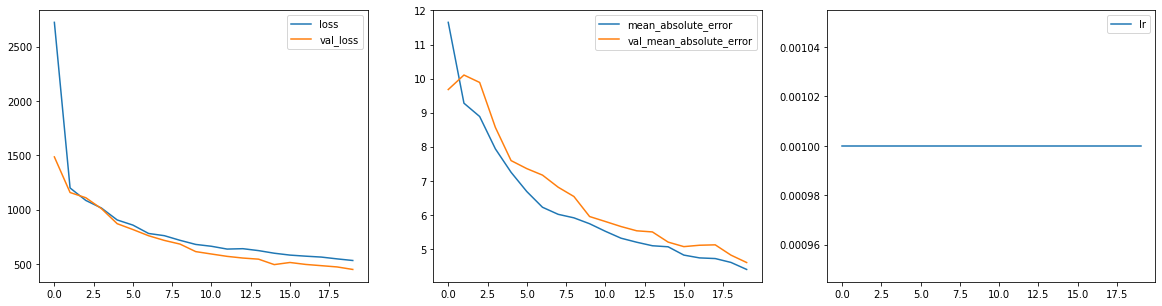

In [17]:
fig = plt.figure(figsize=(20,5))

ax = plt.subplot(131)

epochs = [i for i in range(len(history.history['loss']))]
ax.plot(epochs, history.history['loss'], label='loss')
ax.plot(epochs, history.history['val_loss'], label='val_loss')
plt.legend()

ax = plt.subplot(132)
ax.plot(epochs, history.history['mean_absolute_error'], label='mean_absolute_error')
ax.plot(epochs, history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
plt.legend()

ax = plt.subplot(133)
ax.plot(epochs, history.history['lr'], label='lr')
b = plt.legend()

### **<span style = 'color:brown'>Output Decomposition</span>**<a id ='Decomposition'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

Code Credits: [Forecast with N-BEATS || Interpretable model](https://www.kaggle.com/code/gatandubuc/forecast-with-n-beats-interpretable-model/notebook)

In [18]:
import tensorflow_probability as tfp
tfd = tfp.distributions
from plotly.subplots import make_subplots
import plotly.graph_objects as go
outputs = []
seasonality = []
trend = []
for sample in range(30):
    results = model(dataset.X_test)
    outputs.append(results)
    seasonality.append(model.seasonality)
    trend.append(model.trend)
    
plot_results_nbeats(y_pred=tf.stack(outputs),
                    date_outputs=dataset.test_date,
                    y_true=dataset.y_test,
                    date_history=None,
                    seasonality=tf.stack(seasonality),
                    trend=tf.stack(trend))

### **<span style = 'color:brown'>Model Forecast</span>**<a id ='Forecast'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

In [19]:
outputs = []
seasonality = []
trend = []
for sample in range(50):
    results = model(df[['Indoor_temperature_room']].iloc[-back_horizon:].T.values)
    outputs.append(results)
    seasonality.append(model.seasonality)
    trend.append(model.trend)

Two days forecast from the end date of train data. 

In [20]:
date_forecasting = np.expand_dims(pd.date_range('2012-04-11 06:30:00', '2012-05-01 07:30:00', freq='15T'), axis=0)
date = pd.date_range('2012-03-13 11:45:00', '2012-04-11 06:30:00', freq='15T')

plot_results_nbeats(y_pred=tf.stack(outputs),
                    date_outputs=date_forecasting,
                    y_true=df[['Indoor_temperature_room']].T.values,
                    date_history=date,
                    seasonality=tf.stack(seasonality),
                    trend=tf.stack(trend))